# CoinAPI

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.dates as mdates

In [209]:
import requests
import json

symbol_id = 'ADA'
period_id = '1DAY'
time_start = '2019-05-03T00:00:00'
time_end = '2021-05-06T00:00:00'
limit = '1000'

url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/USD/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
#url = 'https://rest.coinapi.io/v1/symbols'

headers = {
  'Accepts': 'application/json',
  'X-CoinAPI-Key': 'B578CC73-E598-48F9-AA88-86F637222F8D',
}


response = requests.get(url, headers=headers)
data = json.loads(response.text)

In [210]:
df = pd.DataFrame(data)
df = df.drop(['time_period_end', 'time_open', 'time_close'], axis=1)

In [211]:
df['Date'] = pd.to_datetime(df['time_period_start']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop(['time_period_start', 'Date'], axis=1)
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2019-05-03,0.067104,0.074000,0.066500,0.068826,1.105210e+07,1673
2019-05-04,0.069083,0.070949,0.065203,0.066269,8.567252e+06,1145
2019-05-05,0.066259,0.067266,0.064820,0.065500,3.166601e+06,388
2019-05-06,0.065252,0.068150,0.062891,0.066150,4.416848e+06,774
2019-05-07,0.066446,0.068239,0.062900,0.063100,5.940077e+06,1024


In [212]:
df.tail()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2021-05-01,1.3556,1.3700,1.310000,1.3537,5.661885e+07,114347
2021-05-02,1.3535,1.3575,1.295265,1.3284,4.534578e+07,91729
2021-05-03,1.3284,1.3816,1.322300,1.3634,7.371871e+07,132431
2021-05-04,1.3643,1.3681,1.257660,1.2719,1.145964e+08,186570
2021-05-05,1.2716,1.5000,1.260900,1.4813,2.003925e+08,283363


<AxesSubplot:xlabel='Date'>

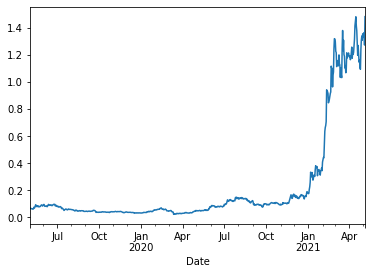

In [213]:
df['price_close'].plot()

In [289]:
def hit_rate(true, pred):
    is_neg = lambda x: 0 if x > 0 else 1
    pos_true = []
    pos_hat = []
    for t in range(len(true)-1):
        pos_true.append(is_neg(np.sign(true[t] - true[t+1])))
        pos_hat.append(is_neg(np.sign(pred[t] - pred[t+1])))
    subtracted = np.abs(np.subtract(pos_hat, pos_true))
    rate = 1 - sum(subtracted)/len(subtracted)
    return rate

def find_returns(true, pred):
    ret_true = []
    ret_hat = []
    for t in range(len(true)-1):
        ret_true.append(((true[t+1] - true[t])/true[t])*100)
        ret_hat.append(((pred[t+1] - pred[t])/pred[t])*100)
    mse = mean_squared_error(ret_true, ret_hat)
    return ret_true, ret_hat, mse
        

def model_selection(data, forecast, dates, minimization='RET'):
    X_train, X_test = data[1:len(data)-forecast], data[len(data)-forecast:]
    dates_test = dates[len(dates)-forecast:]
    # find lag values which maximize hit rate
    rates = []
    for lag in range(1,int(len(X_train)/2)-1):
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = autoreg.forecast(forecast)
        rates.append(hit_rate(X_test, X_hat))
    
    max_hit_lags = [i for i, j in enumerate(rates) if j == max(rates)]
    
    # find lag values which maximize correct returns
    returns = []
    for lag in max_hit_lags:
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = autoreg.forecast(forecast)
        returns.append(find_returns(X_test, X_hat))
    
    if minimization == 'RET':
        mses = [ret[2] for ret in returns]
        min_mse_lags = [max_hit_lags[i] for i,j in enumerate(mses) if j == min(mses)]
        
    elif minimization == 'MSE':
        # find lag values which minimize close price MSE
        mses = []
        for lag in max_hit_lags:
            autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
            X_hat = autoreg.forecast(forecast)
            mses.append(mean_squared_error(X_test, X_hat))
    
        min_mse_lags = [max_hit_lags[i] for i, j in enumerate(mses) if j == min(mses)]
    
    best_returns = [returns[i] for i,j in enumerate(mses) if j == min(mses)]
    
    # Fit model
    lag_order = min_mse_lags[0]
    autoreg = AutoReg(X_train, lags=lag_order, old_names=True).fit()
    X_hat = autoreg.forecast(forecast)
    
    df = pd.DataFrame(data={'returns_true':best_returns[0][0] , 'returns_pred':best_returns[0][1]})
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(dates_test, np.exp(X_test), marker='o', label='Observed')
    plt.plot(dates_test, np.exp(X_hat), marker='o', label='Predicted')
    plt.title(f'{len(X_test)}-Day Prediction')
    plt.ylabel('Close Price (USD)')
    plt.xlabel('Date')
    plt.xticks(fontsize=10)
    plt.legend()
    plt.gcf().autofmt_xdate()
    
    print("Lag:", lag_order)
    print("Hit rate:", rates[lag_order])
    print("Mean Squared Error:", min(mses))
    print(df.head())
    
    
    return min_mse_lags[0], df

Lag: 303
Hit rate: 1.0
Mean Squared Error: 2.2960803691444247
   returns_true  returns_pred
0     63.368286     61.853004


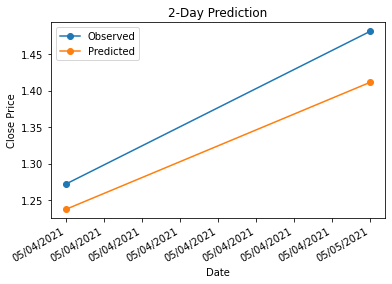

In [310]:
# Prediction and comparison to test set
X = df['price_close'].apply(np.log).values
lag_order, df_returns = model_selection(X, 2, df.index.values, 'RET')

Text(0.5, 1.0, '2-Day Forecast')

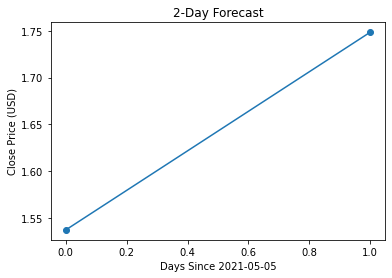

In [321]:
# Forecast with no comparison available, if desired, based on previously selected model
forecast = 2
autoreg = AutoReg(X, lags=lag_order, old_names=True).fit()
X_hat = autoreg.forecast(forecast)
plt.plot(np.exp(X_hat), marker='o')
plt.xlabel(f'Days Since {df.index[-1].date()}')
plt.ylabel('Close Price (USD)')
plt.title(f'{forecast}-Day Forecast')